In [13]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
import collections
import random
import numpy as np
import time
import json
from PIL import Image
import pandas as pd

In [14]:
import os 
os.chdir(r'/kaggle/working')

Έχουμε τα εξής:
- dataset με 31783 images
- train_captions για 29783 images ( 29783x5 = 148915 )
- 2000 test_images 

## Επεξεργασία captions
Επεξεργάζομαι τα 148915(=29783 x 5) train_captions ως dataframes, ώστε να αποκτήσουν το σωστό format.

In [15]:
dff = pd.DataFrame()
dff = pd.read_csv('/kaggle/input/captions/train_captions.csv',header = None)
dff.columns = ['text']

In [16]:
dff

text
0       _1000070808 jpg| 0| A little girl holds orange...
1       _1000070808 jpg| 1| A little girl at a wedding...
2       _1000070808 jpg| 2| Young girl in orange dress...
3       _1000070808 jpg| 3| a girl at a wedding holdin...
4       _1000070808 jpg| 4| A girl holds a bouquet of ...
...                                                   ...
148910  _99999606 jpg| 0| A man in a gray shirt sits w...
148911  _99999606 jpg| 1| A man is sitting down and he...
148912  _99999606 jpg| 2| Older man with shoes in fron...
148913  _99999606 jpg| 3| This man has worked here for...
148914  _99999606 jpg| 4| an old shoemaker in his fact...

[148915 rows x 1 columns]

In [17]:
df_final = pd.DataFrame()
df_final = dff.text.str.split( n=3,expand= True)

def clean(x):
  return x.replace("|","")

df_final[1] = df_final[1].apply(clean) 
df_final[2] = df_final[2].apply(clean)
df_final[0] = df_final[0] + '.' + df_final[1]
del df_final[1]

df_final = df_final.rename( columns = {0 : "image_id", 2: "caption_id" , 3: "caption_text"})

In [18]:
df_final

image_id caption_id  \
0       _1000070808.jpg          0   
1       _1000070808.jpg          1   
2       _1000070808.jpg          2   
3       _1000070808.jpg          3   
4       _1000070808.jpg          4   
...                 ...        ...   
148910    _99999606.jpg          0   
148911    _99999606.jpg          1   
148912    _99999606.jpg          2   
148913    _99999606.jpg          3   
148914    _99999606.jpg          4   

                                             caption_text  
0       A little girl holds orange lilies while others...  
1       A little girl at a wedding holds a bouquet of ...  
2       Young girl in orange dress holding orange flow...  
3         a girl at a wedding holding some orange flowers  
4                       A girl holds a bouquet of flowers  
...                                                   ...  
148910  A man in a gray shirt sits with several pairs ...  
148911  A man is sitting down and he is surrounded by ...  
148912     Older man with shoes in front and behind him    
148913        This man has worked here for many decades    
148914                  an old shoemaker in his factory    

[148915 rows x 3 columns]

Τώρα δημιουργώ ένα dictionary ώστε να αντιστοιχηθεί κάθε εικόνα σε μια λίστα από captions, αφού μας δίνονται 5 captions για κάθε image.

In [19]:
def caption_dict(dff):
  mydict = collections.defaultdict(list)

  for i in range(0,148914) :
    caption = dff['caption_text'].loc[i]
    caption_id = dff['caption_id'].loc[i]
    image_name = '/kaggle/input/dataset/image_dir/' + dff['image_id'].loc[i]
    if(int(caption_id) == 0 ):
       mydict[image_name] = [caption]
    else:
       mydict[image_name].append(caption) 

  return mydict  

In [20]:
image_path_to_caption = caption_dict(df_final)
image_path_to_caption

defaultdict(list,
            {'/kaggle/input/dataset/image_dir/_1000070808.jpg': ['A little girl holds orange lilies while others celebrate an occasion in a garden setting  ',
              'A little girl at a wedding holds a bouquet of orange flowers  ',
              'Young girl in orange dress holding orange flowers  ',
              'a girl at a wedding holding some orange flowers',
              'A girl holds a bouquet of flowers'],
             '/kaggle/input/dataset/image_dir/_100007487.jpg': ['A young child walks down a gravel path lined with a row of red outdoor chairs  ',
              'A racetrack with red chairs stacked beside fence with a child walking  ',
              'A child in a striped shirt walks by some red chairs  ',
              'A child walking and leaving a trail behind them  ',
              'A little kid is walking next to red banners  '],
             '/kaggle/input/dataset/image_dir/_100008804.jpg': ['A woman wearing a green and white shirt and a cap is s

In [22]:
image_paths = list(image_path_to_caption.keys())   #όσες έχουν captions = 29783 / 31783
#random.shuffle(image_paths)    #δεν χρειαζεται

# Select the first 6000 image_paths from the shuffled set.
#train_image_paths = image_paths[:6000]

#select all images
train_image_paths = image_paths  

In [23]:
train_image_paths     #list of img_keys

['/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100019484.jpg',
 '/kaggle/input/dataset/image_dir/_1000235018.jpg',
 '/kaggle/input/dataset/image_dir/_100026480.jpg',
 '/kaggle/input/dataset/image_dir/_100029825.jpg',
 '/kaggle/input/dataset/image_dir/_100041955.jpg',
 '/kaggle/input/dataset/image_dir/_100062307.jpg',
 '/kaggle/input/dataset/image_dir/_100065111.jpg',
 '/kaggle/input/dataset/image_dir/_100070508.jpg',
 '/kaggle/input/dataset/image_dir/_10007492.jpg',
 '/kaggle/input/dataset/image_dir/_100082223.jpg',
 '/kaggle/input/dataset/image_dir/_100090880.jpg',
 '/kaggle/input/dataset/image_dir/_1000954607.jpg',
 '/kaggle/input/dataset/image_dir/_100122568.jpg',
 '/kaggle/input/dataset/image_dir/_100125528.jpg',
 '/kaggle/input/dataset/image_dir/_1001337420.jpg',
 '/kaggle/input/dataset/image_dir/_1001443395.jpg',
 '/kaggle/input/dataset/ima

In [24]:
len(train_image_paths)

29782

In [25]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

#σπάω ένα υπομέρος του dict σε δύο λίστες όπου για θέση i , list1[1] = img_key  list2[i] = img_vector

In [26]:
train_captions           #list of all captions

['A little girl holds orange lilies while others celebrate an occasion in a garden setting  ',
 'A little girl at a wedding holds a bouquet of orange flowers  ',
 'Young girl in orange dress holding orange flowers  ',
 'a girl at a wedding holding some orange flowers',
 'A girl holds a bouquet of flowers',
 'A young child walks down a gravel path lined with a row of red outdoor chairs  ',
 'A racetrack with red chairs stacked beside fence with a child walking  ',
 'A child in a striped shirt walks by some red chairs  ',
 'A child walking and leaving a trail behind them  ',
 'A little kid is walking next to red banners  ',
 'A woman wearing a green and white shirt and a cap is smiling while another woman wearing a gray shirt and white cap is facing her  ',
 'A green sign in several languages mentions Facebook and Twitter while people talk below in the sunlight  ',
 'A group of people are spreading the word about their organization using a piece green construction paper  ',
 'A woman sha

In [27]:
len(train_captions)

148909

In [28]:
img_name_vector     #list apo img_keys

['/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100019484.jpg',
 '/kaggle/input/dataset/image_dir/_100019484.jpg',
 '/kaggle/input/dataset/image_dir/_100019484.jpg',
 '/kaggle/input/dataset/image_dir/_100019484.jpg',
 '/kaggle/input/dataset/im

Two big dogs   brown and tan   are running in grass  


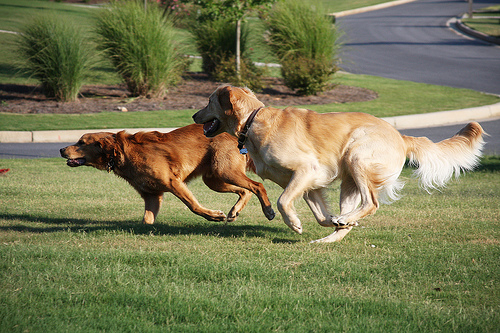

In [29]:
#random image
print(train_captions[130])
Image.open(img_name_vector[130])

In [30]:
import string
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    new_captions = []
    for caption in captions:
            #caption.replace("-"," ")
            desc = caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            caption = ' '.join(desc)
            new_captions.append(caption)
    return new_captions

clean_train_captions = cleaning_text(train_captions)
clean_train_captions

['little girl holds orange lilies while others celebrate an occasion in garden setting',
 'little girl at wedding holds bouquet of orange flowers',
 'young girl in orange dress holding orange flowers',
 'girl at wedding holding some orange flowers',
 'girl holds bouquet of flowers',
 'young child walks down gravel path lined with row of red outdoor chairs',
 'racetrack with red chairs stacked beside fence with child walking',
 'child in striped shirt walks by some red chairs',
 'child walking and leaving trail behind them',
 'little kid is walking next to red banners',
 'woman wearing green and white shirt and cap is smiling while another woman wearing gray shirt and white cap is facing her',
 'green sign in several languages mentions facebook and twitter while people talk below in the sunlight',
 'group of people are spreading the word about their organization using piece green construction paper',
 'woman shakes hand with another woman as they stand under sign for protest they are co

In [31]:
cleaned_train_captions=[]
for caption in clean_train_captions:
   caption = "<start> " + caption + " <end>"
   cleaned_train_captions.append(caption)

cleaned_train_captions

['<start> little girl holds orange lilies while others celebrate an occasion in garden setting <end>',
 '<start> little girl at wedding holds bouquet of orange flowers <end>',
 '<start> young girl in orange dress holding orange flowers <end>',
 '<start> girl at wedding holding some orange flowers <end>',
 '<start> girl holds bouquet of flowers <end>',
 '<start> young child walks down gravel path lined with row of red outdoor chairs <end>',
 '<start> racetrack with red chairs stacked beside fence with child walking <end>',
 '<start> child in striped shirt walks by some red chairs <end>',
 '<start> child walking and leaving trail behind them <end>',
 '<start> little kid is walking next to red banners <end>',
 '<start> woman wearing green and white shirt and cap is smiling while another woman wearing gray shirt and white cap is facing her <end>',
 '<start> green sign in several languages mentions facebook and twitter while people talk below in the sunlight <end>',
 '<start> group of peopl

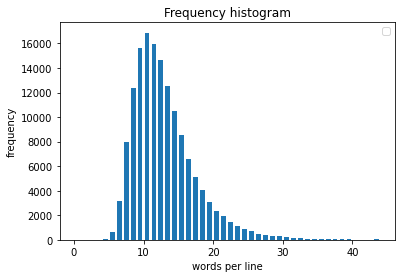

In [32]:
import matplotlib.pyplot as plt  

def bar_chart(descriptions):
  lines = list()
  stats_list = list()
  
  for caption in descriptions:
    stats_list.append(len(caption.split()))
  
  return stats_list

wordsperline = [ i for i in range(45)]

plt.hist(bar_chart(cleaned_train_captions), wordsperline, histtype='bar', rwidth=0.7)
plt.xlabel('words per line')
plt.ylabel('frequency')
plt.title('Frequency histogram')
plt.legend()
plt.show()    

Ό,τι είναι πάνω από 6 και κάτω από 30 το κρατάμε τα υπόλοιπα δεν χρειάζονται γιατί έχουν πολύ μικρή συχνότητα εμφάνισης.

In [33]:
def cut_captions(captions, images):
  cut_captions = []
  cut_images = []
  for caption,image in zip(captions,images):
     if( len(caption.split())>5 and (len(caption.split()))<30 ):
        #index = captions.index(caption)
        cut_captions.append(caption)
        cut_images.append(image)
        #captions.pop(index)
        #images.pop(index)
        
  return cut_captions, cut_images

cut_train_captions, cut_img_name_vector = cut_captions(cleaned_train_captions,img_name_vector)

In [34]:
print(len(cut_train_captions))
print(len(cut_img_name_vector))

147072
147072


Ο αριθμός των captions μειώθηκε κατά 1800. Κατά μικρό ποσοστό δηλαδή.

Αφού τελειώσαμε το preprocessing του dataset συνεχίζουμε με τον encoder. O encoder μας είναι ουσιαστικά ένα CNN που εκπαιδεύτηκε με το imagenet για να κάνει classify εικόνες. Εμείς όμως δεν θέλουμε classify, θέλουμε captions, άρα θέλουμε να τσιμπήσουμε τα χαρ/κα μια εικόνας πριν γίνει classify. Άρα λοιπόν θα βάζουμε ως input εικόνες, αλλά θα παίρνουμε το αποτέλεσμα(κωδικοποίηση της εκάστοτε εικόνας) ένα layer πρίν το τέλος. Στη συνέχεια με βάση αυτό θα βρούμε τα captions που του αντιστοιχούν. 

## Xception processing

In [41]:
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array  
from keras.preprocessing.text import Tokenizer 

To xception θέλει διαστάσεις εικόνων 299x299.

In [42]:
#Πάμε στον encoder τώρα, πρέπει να κάνουμε preprocessing τις εικόνες(φτιάχνουμε το format τους)
# για να γίνουν input στον απαιτούμενο encoder, έχω Xception (299x299)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [43]:
#Εδώ αρχικοποιούμε τον encoder με pretrained data
image_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape = (299,299,3)) #weights= Βάρη που έχουν εκπαιδευτεί στο Imagenet

new_input = image_model.input
hidden_layer = image_model.layers[-1].output     #θέλω να τσιμπήσω τα features στο προτελευταίο layer

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)   # <=> image_features_exctract_mode(new_input)

In [44]:
encode_train = sorted(set(cut_img_name_vector))

In [45]:
encode_train  #all

['/kaggle/input/dataset/image_dir/_1000070808.jpg',
 '/kaggle/input/dataset/image_dir/_100007487.jpg',
 '/kaggle/input/dataset/image_dir/_100008804.jpg',
 '/kaggle/input/dataset/image_dir/_100019484.jpg',
 '/kaggle/input/dataset/image_dir/_1000235018.jpg',
 '/kaggle/input/dataset/image_dir/_100026480.jpg',
 '/kaggle/input/dataset/image_dir/_100029825.jpg',
 '/kaggle/input/dataset/image_dir/_100041955.jpg',
 '/kaggle/input/dataset/image_dir/_100062307.jpg',
 '/kaggle/input/dataset/image_dir/_100065111.jpg',
 '/kaggle/input/dataset/image_dir/_100070508.jpg',
 '/kaggle/input/dataset/image_dir/_10007492.jpg',
 '/kaggle/input/dataset/image_dir/_100082223.jpg',
 '/kaggle/input/dataset/image_dir/_100090880.jpg',
 '/kaggle/input/dataset/image_dir/_1000954607.jpg',
 '/kaggle/input/dataset/image_dir/_100122568.jpg',
 '/kaggle/input/dataset/image_dir/_100125528.jpg',
 '/kaggle/input/dataset/image_dir/_1001337420.jpg',
 '/kaggle/input/dataset/image_dir/_1001443395.jpg',
 '/kaggle/input/dataset/ima

Το παρακάτω χρησιμοποιήθηκε μία φορά στην αρχή ώστε να δημιουργηθούν οι Numpy εικόνες. Μετά έκανα «commit and run» το τρέχον και το αποθήκευσα ως dataset στο input.  

In [38]:
!pip install tqdm
from tqdm import tqdm

Τον παρακάτω κώδικα τον έτρεξα μια φορά, έκανα commit το Notebook και μετά ανέβασα το output ως dataset.

In [ ]:
# Feel free to change batch_size according to your system configuration
#image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)  

# αποθήκευση των image features σε npy  
#for img, path in tqdm(image_dataset): 
#  batch_features = image_features_extract_model(img)   
#  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

#  for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     head , tail = os.path.split(path_of_feature)
#     save_path = '/kaggle/working/'+ tail
#     np.save(save_path, bf.numpy())

## Δημιουργία vocab
Συνεχίζουμε να επεξεργαζόμαστε τα captions με χρήση tokenizer, για δημιουργήσουμε word_vocabulary. Έχουμε ήδη από πριν εκκαθαρίσει τα περιττά captions. Επομένως ξέρουμε το maxlength (30). 

In [46]:
#ο tokenizer θέλει format dataset για αν δουλέψει,άρα μετατρέπω τη list με τα captions
caption_dataset = tf.data.Dataset.from_tensor_slices(cut_train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")   #[]

# Max word count for a caption.
max_length = len( max(cut_train_captions, key = len) ) # αυτό που προέκυψε στο διάγραμμα μεταξύ 5 και 30

# Use the top 5000 words for a vocabulary.            # στο Xception 8000 words
vocabulary_size = 8000        # size of vocabulary just created

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,                  #εφαρμόζεται στο input text, δηλαδή στο caption_dataset
    output_sequence_length=max_length
)
# Learn the vocabulary from the caption data. 
tokenizer.adapt(caption_dataset)              #η adapt είναι για να δημιουργήσεις vocab από τα δεδομένα σου


tokenizer.vocabulary_size()       #επιστρέφει το πλήθος των λέξεων

tokenizer.get_vocabulary()        #επιστρέφει το vocabulary που δημιουργήθηκε

voc = tokenizer.get_vocabulary()


2022-03-09 15:53:12.514615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [47]:
voc

['',
 '[UNK]',
 '<start>',
 '<end>',
 'in',
 'the',
 'on',
 'and',
 'man',
 'is',
 'of',
 'with',
 'woman',
 'two',
 'are',
 'people',
 'to',
 'at',
 'an',
 'wearing',
 'young',
 'white',
 'shirt',
 'black',
 'while',
 'his',
 'blue',
 'red',
 'sitting',
 'girl',
 'men',
 'boy',
 'standing',
 'dog',
 'playing',
 'street',
 'group',
 'down',
 'front',
 'walking',
 'her',
 'holding',
 'one',
 'water',
 'three',
 'by',
 'women',
 'green',
 'child',
 'up',
 'looking',
 'for',
 'as',
 'little',
 'outside',
 'large',
 'yellow',
 'person',
 'children',
 'brown',
 'through',
 'their',
 'from',
 'hat',
 'ball',
 'other',
 'small',
 'into',
 'next',
 'over',
 'some',
 'out',
 'dressed',
 'running',
 'riding',
 'jacket',
 'building',
 'another',
 'around',
 'orange',
 'near',
 'field',
 'crowd',
 'beach',
 'stands',
 'sidewalk',
 'pink',
 'behind',
 'background',
 'table',
 'jumping',
 'girls',
 'grass',
 'sits',
 'snow',
 'bike',
 'looks',
 'that',
 'asian',
 'camera',
 'top',
 'dogs',
 'air',
 

In [49]:
len(voc)

8000

In [50]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# χρησιμοποιούμε το παρακάτω για να μπορέσουμε να δούμε τα tokenized vectors
list(cap_vector.as_numpy_iterator())
#όντως, βλέπουμε πολλά arrays με 30 τιμές ο καθένας, 
#αλλά μή μηδενικές τιμές μόνο στις θέσεις που αντιστοιχούν οι λέξεις του caption

[array([   2,   53,   29,  139,   79,    1,   24,  303, 2400,   18, 4788,
           4,  689,  400,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [51]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)    

Τώρα έχουμε φτιάξει τo tokenized vocab (μεγέθους 8000 λέξεων) , οπότε θα ετοιμάσουμε τα data για training.

In [52]:
img_to_cap_vector = collections.defaultdict(list)            #initialize dict

for img, cap in zip(cut_img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)                         #αντιστοιχίζεται κάθε img_name στο tokenized caption

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]   #το σπάμε σε δύο ομάδες(80-20)
 
#για τα training images
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

#για τα testing images
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(117649, 117649, 29423, 29423)

Τα κάνουμε datasets για να γίνει training στο Model. To Xception έχει features_shape= 2048 και atterntion_shape=100. Ωστόσο ως embedding_dim επέλεξα διάφορες τιμές 50,100,200,300. Τελικά για dimension 100 βρήκα βέλτιστο μοντέλο και αυτό φαίνεται παρακάτω. Επίσης, δοκίμασα και διάφρες τιμές για τα units του RNN 250, 1024. Ομοίως βρήκα βέλτιστο μοντέλο για 1024. Αυτοί οι παράμετροι εμφανίζονται παρακάτω.   

In [53]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000       # 1000
embedding_dim = 100      # 50, 100 , 200, 300 
units = 1024             # 250, 512, 1024 
num_steps = len(img_name_train) # BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)  , εγώ xception  (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load('../input/labor3/' + os.path.basename(img_name.decode('utf-8'))+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))    #training , testing

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function( map_func, [item1, item2], [tf.float32, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [54]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

## EMBEDDINGS
Αποθήκευσα ως dataset έτοιμα word_embeddings από το GloVe με dimensions (50,100,200,300), ώστε να μη χρειάζεται κάθε φορά να εκπαιδεύονται τα βάρη τους.  

In [55]:
path_to_glove_file = "../input/embeddings/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


num_tokens = len(voc)
#embedding_dim = 100
hits = 0
misses = 0
word_index = dict(zip(voc, range(len(voc))))

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 7839 words (161 misses)


In [56]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [57]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding

In [58]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = Embedding(      #changed
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False
    )
    
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [59]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

optimizer = tf.keras.optimizers.Adam()

In [60]:
#Loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [61]:
def restore_model(checkpoint_path, encoder, decoder, optimizer):
    ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    ckpt.restore(ckpt_manager.latest_checkpoint)

    if ckpt_manager.latest_checkpoint:
        print("Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    return encoder, decoder, optimizer

Η παραπάνω συνάρτηση «ανασύρει» τα αποθηκευμένα μοντέλα από το checkpoint dataset-φάκελο του input.

In [ ]:
#ckpt.restore(ckpt_manager.latest_checkpoint)

encoder, decoder, optimizer = restore_model( "../input/checkp" + "/checkpoints/train1", encoder, decoder, optimizer)

##### Train

In [62]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [63]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

##### Main training

In [64]:
letsTrain = True #helper

In [2]:
start_epoch = 0
EPOCHS = 20

if letsTrain:
    for epoch in range(start_epoch, EPOCHS):
        print("\n\nEPOCH: {}".format(epoch))
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            # print(batch, end=' ')
            # print(img_tensor.shape, target.shape)
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)


        print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

 Epoch 1 Batch 0 Loss 2.00236
 Epoch 1 Batch 100 Loss 1.9330
 Epoch 1 Batch 200 Loss 1.7881
 Epoch 1 Batch 300 Loss 1.7240
 Epoch 1 Batch 400 Loss 1.5753
 Epoch 1 Loss 1.841721
 Time taken for 1 epoch 256.18 sec

 Epoch 2 Batch 0 Loss 1.8586
 Epoch 2 Batch 100 Loss 1.5822
 Epoch 2 Batch 200 Loss 1.4830
 Epoch 2 Batch 300 Loss 1.4957
 Epoch 2 Batch 400 Loss 1.3378
 Epoch 2 Loss 1.520530
 Time taken for 2 epoch 216.27 sec
 
 Epoch 3 Batch 0 Loss 1.5033
 Epoch 3 Batch 100 Loss 1.2804
 Epoch 3 Batch 200 Loss 1.4838
 Epoch 3 Batch 300 Loss 1.4329
 Epoch 3 Batch 400 Loss 1.2113
 Epoch 3 Loss 1.382894
 Time taken for 3 epoch 216.32 sec
 
 Epoch 4 Batch 0 Loss 1.4805
 Epoch 4 Batch 100 Loss 1.2645
 Epoch 4 Batch 200 Loss 1.3427
 Epoch 4 Batch 300 Loss 1.2173
 Epoch 4 Batch 400 Loss 1.1872
 Epoch 4 Loss 1.278689
 Time taken for 4 epoch 216.33 sec
 
 Epoch 5 Batch 0 Loss 1.2698
 Epoch 5 Batch 100 Loss 1.2304
 Epoch 5 Batch 200 Loss 1.1323
 Epoch 5 Batch 300 Loss 1.2603
 Epoch 5 Batch 400 Loss 1.

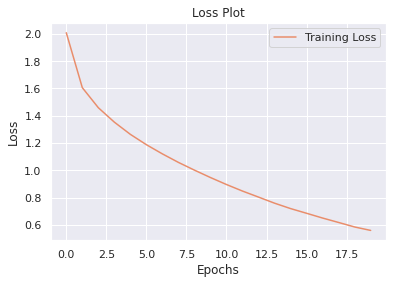

In [1]:
#plot train loss
plt.plot(loss_plot, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

## Evaluate

In [65]:
#for given image find hypothesis caption
def evaluate(image):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions,1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result    #, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    return result     # , attention_plot

## BLEU 
Θα χρησιμοποιήσω ως reference ένα ποσοστό του validation set, αφού 20% του συνολικού train set είναι αρκετά μεγάλο (5957 captions).
Διαλέγω το 25% άρα 1500 captions.




In [66]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [68]:
# captions on the validation set

def sentence_score():
 rid = 0 #random.randrange( 23826, 29783)  # number of image
 image = img_name_val[rid]
 ref = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]])
 ref_caption = ref.split()
 hyp_caption = evaluate(image)
 weights = (0.4, 0.3, 0.2, 0.1)
 smoothing_function = SmoothingFunction().method1
 img_score = sentence_bleu([ref_caption], hyp_caption, weights , smoothing_function  )
 return image,ref_caption, hyp_caption, img_score   

In [69]:
img, ref, hyp, score = sentence_score()

Στη συνέχεια καθαρίζω το αρχικό dictionary ώστε να μπορώ να συγκρίνω τα original captions με τα hypothesis. 

In [70]:
import string
def cleaning_dict(dictionary):
    table = str.maketrans('','',string.punctuation)
    new_captions = {}
    for key, captions in dictionary.items():
        new_caption = []
        for caption in captions:
            caption.replace("-"," ")
            desc = caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            new_caption.append(desc)
        new_captions[key] = new_caption
    return new_captions

clean_train_caption_dict = cleaning_dict(image_path_to_caption)

In [71]:
clean_train_caption_dict

{'/kaggle/input/dataset/image_dir/_1000070808.jpg': [['little',
   'girl',
   'holds',
   'orange',
   'lilies',
   'while',
   'others',
   'celebrate',
   'an',
   'occasion',
   'in',
   'garden',
   'setting'],
  ['little',
   'girl',
   'at',
   'wedding',
   'holds',
   'bouquet',
   'of',
   'orange',
   'flowers'],
  ['young', 'girl', 'in', 'orange', 'dress', 'holding', 'orange', 'flowers'],
  ['girl', 'at', 'wedding', 'holding', 'some', 'orange', 'flowers'],
  ['girl', 'holds', 'bouquet', 'of', 'flowers']],
 '/kaggle/input/dataset/image_dir/_100007487.jpg': [['young',
   'child',
   'walks',
   'down',
   'gravel',
   'path',
   'lined',
   'with',
   'row',
   'of',
   'red',
   'outdoor',
   'chairs'],
  ['racetrack',
   'with',
   'red',
   'chairs',
   'stacked',
   'beside',
   'fence',
   'with',
   'child',
   'walking'],
  ['child', 'in', 'striped', 'shirt', 'walks', 'by', 'some', 'red', 'chairs'],
  ['child', 'walking', 'and', 'leaving', 'trail', 'behind', 'them'],
  

In [74]:
from random import sample

def corpus_bleu():
 ref_list = sample(range(23826, 29432), 1500)     #23826 = 29783 -  - 0.2*29783
 ref_cap_list = []
 hypothesis_cap_list = []   

 for rid in ref_list:
  image = img_name_val[rid]
  ref = clean_train_caption_dict[image]                    # [[]...[]...[]]
  ref_cap_list.append(ref)                                 # [ [[],[],[],[]], [..], ... , [ ]]
  hypothesis = evaluate(image)                             # [['...'], ['...'], ... , ['...']]
  hypothesis_cap_list.append(hypothesis)
  
  weights = (0.4, 0.3, 0.2, 0.1)
  smoothing_function = SmoothingFunction().method1
  corpus_score = corpus_bleu(ref_cap_list, hypothesis_cap_list, weights, smoothing_function)   
 return ref_caption 

In [75]:
corpus_bleu()

0.162045


Επίλεξα τις παρακάτω εικόνες, γιατί περιέχουν διακριτά αντικείμενα.

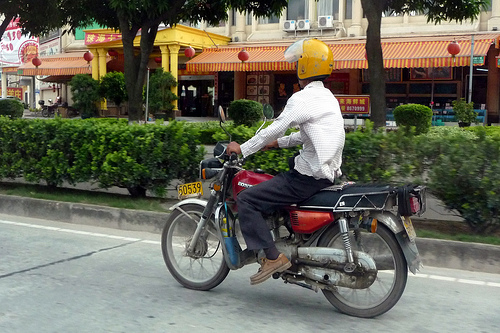

In [16]:
Image.open('/kaggle/input/dataset/image_dir/_97994182.jpg')  #_99259122.jpg

In [19]:
ref_captions = clean_train_caption_dict['/kaggle/input/dataset/image_dir/_97994182.jpg']

for cap in ref_captions: print(cap)
    
image = img_name_val[147959]
predicted = evaluate(image)
print("predicted caption:", predicted)

['man', 'in', 'yellow', 'helmet', 'white', 'shirt', 'and', 'blue', 'pants', 'rides', 'red', 'motorbike', 'past', 'low', 'hedge']
['man', 'wearing', 'yellow', 'helmet', 'with', 'his', 'visor', 'up', 'rides', 'red', 'motorbike']
['man', 'wearing', 'yellow', 'helmet', 'is', 'riding', 'on', 'his', 'red', 'motorcycle']
['man', 'rides', 'his', 'motorcycle', 'down', 'the', 'street']
['person', 'in', 'helmet', 'on', 'motorcycle']
predicted caption: ['a', 'man', 'riding', 'a', 'bike', 'on', 'a', 'walk']


Παραθέτω τα captions που βρήκα για την παραπάνω εικόνα για κάθε μοντέλο:
- default:    ['a', 'man', 'on', 'the', 'other', 'helmet']
- ενδιάμεσο: ['a', 'man', "viewing', 'road', 'on', 'wheel']
- βέλτιστο:   ['a', 'man', 'riding', 'a', 'bike', 'on', 'a', 'walk'] 

Στο default παρατηρώ εντοπίζει ότι είναι άνθρωπος, όπως και το κράνος αλλά αγνοεί τη μηχανή.

Ενδιάμεσα, λόγω των έτοιμων embeddings παρατηρώ ότι υπάρχει μεγαλύτερη ποικιλία στα predicted words, χωρίς ωστόσο απόλυτη επιτυχία.

Στο βέλτιστο Model, παρατηρώ ότι τα βασικά στοιχεία εμφανίζονται(άνθρωπος, μηχανή, οδηγεί). 

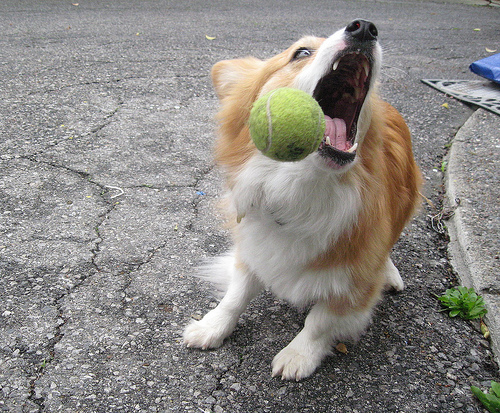

In [20]:
Image.open('/kaggle/input/dataset/image_dir/_9944602.jpg')

In [21]:
ref_captions = clean_train_caption_dict['/kaggle/input/dataset/image_dir/_9944602.jpg']

for cap in ref_captions: print(cap)
    
image = img_name_val[143242]
predicted = evaluate(image)
print("predicted caption:", predicted)

['brown', 'and', 'white', 'dog', 'on', 'road', 'with', 'its', 'mouth', 'open', 'near', 'tennis', 'ball']
['brown', 'and', 'white', 'dog', 'has', 'is', 'mouth', 'open', 'ready', 'to', 'catch', 'green', 'ball']
['yellow', 'and', 'white', 'dog', 'is', 'catching', 'tennis', 'ball', 'on', 'street']
['gold', 'and', 'white', 'dog', 'catching', 'tennis', 'ball', 'in', 'its', 'mouth']
['small', 'dog', 'catches', 'green', 'tennis', 'ball', 'in', 'its', 'mouth']
predicted caption: ['a', 'dog', 'catching', 'a', 'competition', 'on', 'field']


Παραθέτω τα captions που βρήκα για την παραπάνω εικόνα για κάθε μοντέλο:
- default:   ['a', 'dog', 'is', 'mouth', 'the', 'grass']
- ενδιάμεσο: ['dog', 'eating', 'the', 'mouth', 'of', 'frisbee']
- βέλτιστο:  ['a', 'dog', 'catching', 'a', 'competition', 'on', 'field']  

Στο default παρατηρώ εντοπίζει ότι είναι σκύλος, όπως και το στόμα αλλά αγνοεί τη μηχανή.

Ενδιάμεσα, λόγω των έτοιμων embeddings παρατηρώ ότι προστίθεται και κίνηση(eating), χωρίς ωστόσο απόλυτη επιτυχία.
Στο βέλτιστο Model, παρατηρώ ότι περιέχει την κίνηση και το τόπο(field).

Ωστόσο, αγνοεί εντελώς ότι πρόκειται για μπαλάκι του τένις. Αυτό οφείλεται στο overfitting. Έχει γίνει υπερβολική εκπαίδευση σε εικόνες με σκύλους πάνω σε γρασίδι που πιάνουν frisbee, οπότε το μοντέλο θεωρεί πως σκύλος θα είναι πάνω σε γρασίδι, θα τρέχει ή θα κηνυγά frisbee.  

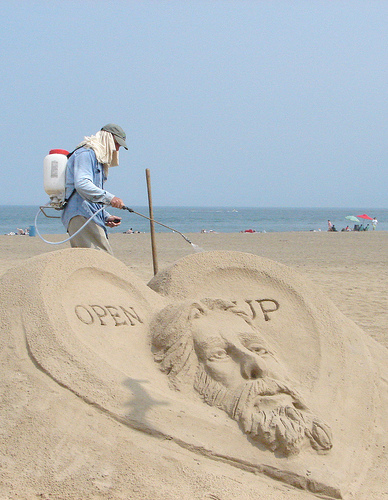

In [28]:
Image.open('/kaggle/input/dataset/image_dir/_101029776.jpg')

In [30]:
ref_captions = clean_train_caption_dict['/kaggle/input/dataset/image_dir/_101029776.jpg']

for cap in ref_captions: print(cap)
    
image = img_name_val[147512]
predicted = evaluate(image)
print("predicted caption:", predicted)

['man', 'with', 'white', 'covering', 'on', 'is', 'face', 'spraying', 'water', 'on', 'mound', 'of', 'sand', 'with', 'heart', 'drawn', 'that', 'says', 'open', 'up']
['man', 'is', 'spraying', 'fluid', 'from', 'long', 'hose', 'at', 'the', 'beach']
['man', 'in', 'blue', 'shirt', 'is', 'spraying', 'sand', 'sculpture']
['man', 'sprays', 'sand', 'image', 'of', 'man']
['man', 'brushes', 'image', 'in', 'the', 'sand']
predicted caption: ['a', 'group', 'of', 'people', 'standing', 'above', 'of', 'a', 'sandy', 'beach']


Παραθέτω τα captions που βρήκα για την παραπάνω εικόνα για κάθε μοντέλο:

- default: ['a', 'little', 'girl', 'in', 'the', 'sand', 'holding', 'a', 'shaved', 'head', 'wrap', 'himself']
- ενδιάμεσο: ['a', 'person', 'on', 'a', 'beach', 'with', 'a', 'surfboard'] 
- βέλτιστο: ['a', 'group', 'of', 'people', 'standing', 'above', 'of', 'a', 'sandy', 'beach']

Στο default παρατηρώ ότι εντοπίζει την άμμο,ότι πρόκειται για άνθρωπο και ότι κάτι κρατάει, χωρίς όμως να αντιλαμβάνεται το sculpture στη παραλία.

Ενδιάμεσα, λόγω των έτοιμων embeddings παρατηρώ ότι υπάρχει μεγαλύτερη ποικιλία στα predicted words, το beach προφανώς «ταιριάζει» με το surfboard, επομένως επιλέγεται ως επόμενη λέξη λανθασμένα. 

Στο βέλτιστο Model, φαίνεται να εντοπίζει και τους ανθρώπους στο βάθος καθώς και την υψομετρική διαφορά σε σχέση με την άμμο. 

Σε όλα τα παραπάνω αδυνατεί να εντοπίσει το εξάρτημα, λογικό, αφού δεν έχει εκπαιδευτεί σε παρόμοιο.

## Συμπεράσματα - Παρατηρήσεις

### Έτρεξα τον κώδικα για διάφορες παραμέτρους:
- με default embeddings που δημιουργούνται κατα τη διάρκεια
- με διάφορα έτοιμα embeddings από το gensim (50,100,200,300)
- με gru 250, 516(default), 1024 και lstm

Η προεπεξεργασία των captions δεν επιφέρει καμία ουσιαστική αλλαγή στις τιμές των μετρικών, εξάλλου τα captions που αφαιρέθηκαν ήταν ελάχιστα σε σχέση με το σύνολο. 

Για το default μοντέλο υπήρχε αστοχία τόσο στο Bleu όσο και στο Loss. Ωστόσο, παρατήρησα πως το μοντέλο μπορούσε να διακρίνει βασικά χαρακτηριστικά της εικόνας. Αν υπάρχει άνθρωπος ή ζώο στην εικόνα, κινήσεις του και χρώμα αντικειμένου.

Για το μοντέλο με pre-trained embeddings ουσιαστική διαφορά παρουσιαστηκε για emb_dim = 300.

Για το μοντέλο με gru η αύξηση των units του RNN αύξησε το corpus_bleu και μειώθηκε επίσης αισθητά το Loss.
Για μείωση των units από την άλλη παρατηρούμε ότι η ποιότητα των predicted captions(bleu_score) δεν επηρεάστηκε αισθητά, παρόλο που αυξήθηκε σημαντικά το caption loss.

Γενικά, δεν διακρίνουμε κάποια αλληλεξάρτηση μεταξύ των μετρικών bleu και Loss.

| default     | bleu_score      | loss     |
| ---         | ---   |  ---   |
| emb_dim(=256), gru(=512)  |  0.114364     |  0.542371    | 

| gensim emb  | bleu_score     | loss |
| ---         | ---   |    --- |
| 50          |  0.121034     | 0.529921  |
| 100         |  0.159252     | 0.511820   |
| 200         |  0.154921     | 0.528712    |
| 300         |  0.161023     | 0.504367    |

| gru         | bleu_score      | loss     |
| ---         | ---   |  ---   |
| 1024        | 0.161954 |   0.469624  |  
| 512         | 0.116364      |  0.542371   | 
| 250         | 0.154195   |   0.633418   | 



για αύξηση τιμών των παραμέτρων (embeddings, units) αυξανόταν και ο χρόνος εκπαίδευσης του μοντέλου.
Τελικά, μετά από αρκετούς συνδυασμούς κατέληξα ότι το βέλτιστο corpus_bleu = 0.162045 με loss=0.543477 προκύπτει για emb_dim = 100 , units=1024.

** Είναι βέλτιστο εκπαιδεύσεις τέτοιου μεγέθους να γίνονται τοπικά και όχι σε cloud.

## Πηγές

https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00571-w

https://github.com/vybhav72954/Automated_Image_Captioning/blob/master/caption_generator_Xception.py

https://www.tensorflow.org/tutorials/text/image_captioning

https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24

https://iq.opengenus.org/image-captioning-using-keras/